# Homework: Calculate IOD Composites from SST Data

In this homework, you will calculate SST composites based on the Dipole Mode Index (DMI). The DMI is used to quantify the strength of the Indian Ocean Dipole (IOD), a climate phenomenon in the Indian Ocean. The DMI is calculated as the difference in SST anomalies between two specific regions:

- Western Indian Ocean (10S-10N, 50E-70E)
- Southeastern Indian Ocean (10S-0, 90E-110E)

When the SST in the western region is warmer than in the eastern region, a positive IOD event occurs, while the opposite leads to a negative IOD event. These phases affect climate patterns across surrounding regions, making the DMI a useful tool for understanding regional climate variability.




The task is structured to guide you through the key steps we've covered in the previous sessions:

1. Load and preprocess SST data, choose the same period as in the excercises ([`session_2_notebook.ipynb`](../Session2_DataHandling/session_2_notebook.ipynb)).
2. Calculate anomalies and detrend the SST data.
3. Calculate the DMI from the monthly detrended SST anomalies.
4. Calculate SST composites based on positive and negative IOD events.
5. Plot the results over the Indian Ocean, visualizing both positive and negative IOD phases.



You are encouraged to use the script [`enso_functions.py`](../Session2_DataHandling/enso_functions.py) as a reference. Within this script, you will find functions and calculations similar to what you need for this task. Feel free to copy and adapt the relevant code snippets as needed for your calculations.


I guess you will need the following libraries: 

In [2]:

# Standard libraries
#import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy.signal import detrend

Good luck with the task!

#### Step 1: Load and slice the SST data

Period: 1960-2023

In [ ]:
# Your code here ...
# Load the dataset from Url
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
#datapath= '../Data/SST/sst.mnmean.nc'
ds_sst = xr.open_dataset(url)


# Slice the data for the desired period (e.g., 1960-2023)
ds_sst = ds_sst.sel(time=slice('1960', '2023'))

# load data into memory
ds_sst.load()

<xarray.Dataset> Size: 49MB
Dimensions:    (lat: 89, lon: 180, time: 768, nbnds: 2)
Coordinates:
  * lat        (lat) float32 356B 88.0 86.0 84.0 82.0 ... -84.0 -86.0 -88.0
  * lon        (lon) float32 720B 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 6kB 1960-01-01 1960-02-01 ... 2023-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 12kB 9.969e+36 9.969e+36 ... 9.969e+36
    sst        (time, lat, lon) float32 49MB -1.8 -1.8 -1.8 -1.8 ... nan nan nan
Attributes: (12/39)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    data_modified:                   2024-11-03
    DODS_EXTRA.Unlimited_Dimension:  time

#### Step 2: Calculate SST Anomalies


Text(0.5, 1.0, 'Climatology for January')

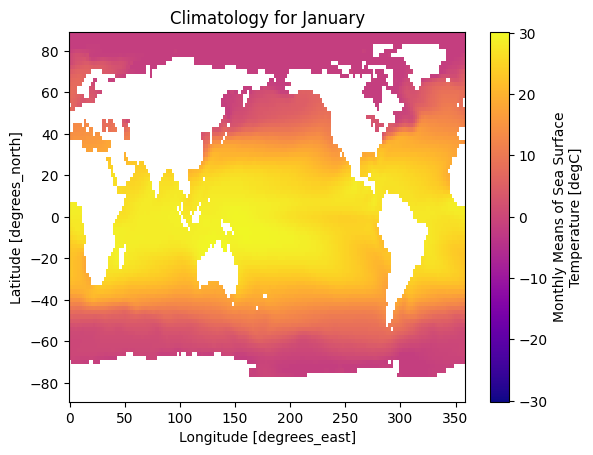

In [4]:
# Calculate the monthly climatology (1960-2023)
sst_climatology = ds_sst['sst'].groupby('time.month').mean(dim='time')

# Subtract the climatology to calculate anomalies
sst_anom = ds_sst['sst'].groupby('time.month') - sst_climatology

# Plot the climatology for reference
sst_climatology.sel(month=1).plot(cmap='plasma')
plt.title('Climatology for January')

#### Step 3: Detrend the SST Data
To remove long-term trends (e.g., warming), we will detrend the anomalies using the `detrend` function. This will allow us to focus on interannual variability, which is crucial for capturing IOD events.


In [5]:
sst_anom_detrended = xr.apply_ufunc(
    detrend, sst_anom.fillna(0), input_core_dims=[['time']], output_core_dims=[['time']],
    dask='allowed'
).where(~sst_anom.isnull())


#### Step 4. Calculate the DMI based on the difference between the western and the southeastern Indian Ocean detrended SST anomalies

Calculate the DMI as a 3 month rolling mean. You can refer to the function `calculate_nino34_index` in [`enso_functions.py`](../Session2_DataHandling/enso_functions.py), which calculates a 5-month rolling mean...

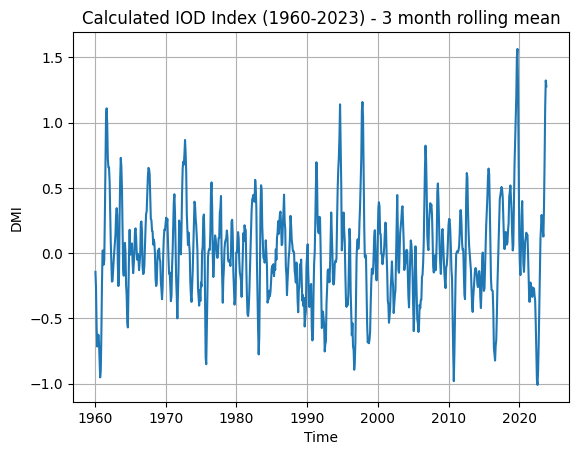

In [6]:
# Define the first region (10S to 10N, 50E to 70E)
region1 = sst_anom_detrended.sel(lat=slice(10, -10), lon=slice(50, 70))

# Define the second region (10S to 0, 90E to 110E)
region2 = sst_anom_detrended.sel(lat=slice(0, -10), lon=slice(90, 110))

# Calculate the area-averaged SST anomaly for each region
mean_region1 = region1.mean(dim=['lat', 'lon'])
mean_region2 = region2.mean(dim=['lat', 'lon'])

# Compute the IOD index as the difference between the two regions
dmi = mean_region1 - mean_region2

# Calculate a 3-month rolling mean for the IOD index
dmi_3month = dmi.rolling(time=3, center=True).mean()
# Plot the calculated IOD index
dmi_3month.plot()
plt.title('Calculated IOD Index (1960-2023) - 3 month rolling mean')
plt.ylabel('DMI')
plt.xlabel('Time')
plt.grid(True)
plt.show()


Positive IOD events are identified when the thee-month rolling mean DMI is 0.4°C or above (-0.4°C for negative events) for at least three consecutive month between June and November. More infos here: https://ds.data.jma.go.jp/tcc/tcc/products/elnino/iodevents.html

To implement this, review the `calculate_composites` function, where composites are calculated for Enso using a six-month rolling window. The key difference here is that you need to focus specifically on the months between June and November, filtering the data accordingly. So, you need to check if the DMI is above the threshold for at least three months and if these months fall between June and November. This involves testing two conditions. 

There are several methods to filter for specific months. You can use your favorite search engine to explore how to filter for a particular month in xarray, for example by searching 'xarray filter specific month'. [Stack Overflow](https://stackoverflow.com/questions/40272222/select-xarray-pandas-index-based-on-specific-months) or the xarray documentation might give you a few useful examples.

The result should be a boolean mask (True/False values).

In [7]:
# Identify positive IOD events: when dmi index > 0.4 for 3 consecutive months using a rolling sum

positive_iod = ((dmi_3month > 0.4).astype('b')
                .rolling(time=3, center=True).sum() >= 3) & dmi_3month['time.month'].isin([6, 7, 8, 9, 10, 11])

negative_iod = ((dmi_3month < -0.4).astype('b')
                .rolling(time=3, center=True).sum() >= 3) & dmi_3month['time.month'].isin([6, 7, 8, 9, 10, 11])


In [8]:
negative_iod

<xarray.DataArray (time: 768)> Size: 768B
array([False, False, False, False, False,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
...
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])
Coordinates:
  * time     (time) datetime64[ns] 6kB 1960-01-01 1960-02-01 ... 2023-12-01
    month    (time) int64 6kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12

In [9]:
dmi_3month.time.dt.month.isin([6, 7, 8, 9, 10, 11])
                              

<xarray.DataArray 'month' (time: 768)> Size: 768B
array([False, False, False, False, False,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True, False,
...
        True,  True,  True,  True,  True, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True, False])
Coordinates:
  * time     (time) datetime64[ns] 6kB 1960-01-01 1960-02-01 ... 2023-12-01
    month    (time) int64 6kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12

### Step 5: Calculate the composites for positive and negative IOD phases and plot them

The boolean mask can now be used together with `where()` to filter the detrended SST anomaly data accordingly and calculate the mean.



In [10]:
# Calculate the composites (mean SST anomalies) for positive and negative IOD phases
sst_positive_iod = sst_anom_detrended.where(positive_iod).mean(dim='time')
sst_negative_iod = sst_anom_detrended.where(negative_iod).mean(dim='time')


# Slice the data for the Indian Ocean region (30E to 120E, 40S to 30N)
indian_ocean_sst_pos = sst_positive_iod.sel(lat=slice(30, -40), lon=slice(30, 120))
indian_ocean_sst_neg = sst_negative_iod.sel(lat=slice(30, -40), lon=slice(30, 120))


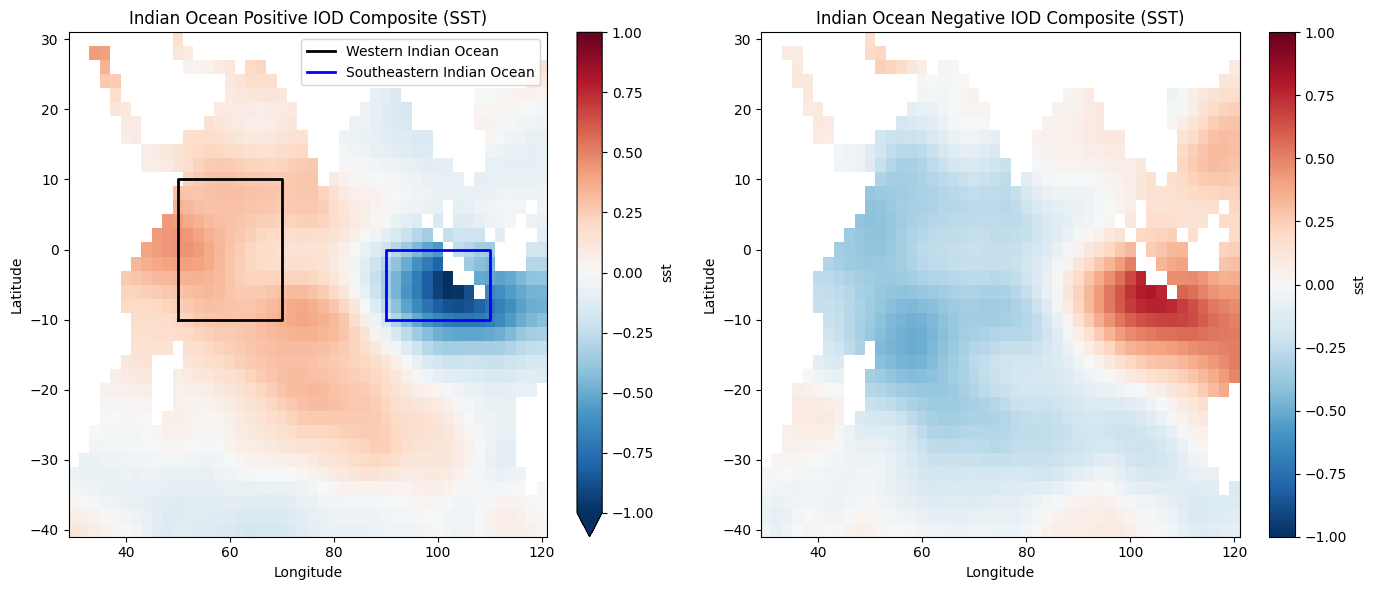

In [11]:
# Plot the SST composites
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Indian Ocean Positive IOD
indian_ocean_sst_pos.plot(ax=ax[0], cmap='RdBu_r', vmin=-1, vmax=1)
ax[0].set_title('Indian Ocean Positive IOD Composite (SST)')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

# Add boxes for western and southeastern Indian Ocean regions (used for IOD calculation)
# Western Indian Ocean box (10S-10N, 50E-70E)
ax[0].plot([50, 50, 70, 70, 50], [-10, 10, 10, -10, -10], color='black', linewidth=2, label='Western Indian Ocean')

# Southeastern Indian Ocean box (10S-0, 90E-110E)
ax[0].plot([90, 90, 110, 110, 90], [-10, 0, 0, -10, -10], color='blue', linewidth=2, label='Southeastern Indian Ocean')

ax[0].legend(loc='upper right')

# Indian Ocean Negative IOD
indian_ocean_sst_neg.plot(ax=ax[1], cmap='RdBu_r', vmin=-1, vmax=1)
ax[1].set_title('Indian Ocean Negative IOD Composite (SST)')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

# Adjust layout
plt.tight_layout()
plt.show()